## Import required packages

In [4]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=e23cd4685ba3980e34daca2b2ac509f368964f101f14f26c22cb43c341e717f9
  Stored in directory: /root/.cache/pip/wheels/27/4d/3a/6dcdf7c3ebc87bf1ae013d96c9cf060ccfe334bb5ee769f377
Successfully built imutils


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, metrics
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [6]:
from tensorflow import keras
print(keras.__version__)
print(tf.__version__)

2.2.4-tf
2.1.0


In [83]:
dataset_path = './dataset'

## Build Dataset

In [84]:
%%bash
rm -rf dataset
mkdir -p dataset/train/covid
mkdir -p dataset/test/covid
mkdir -p dataset/train/normal
mkdir -p dataset/test/normal
mkdir -p dataset/train/pneumonia
mkdir -p dataset/test/pneumonia

### Covid xray dataset

In [85]:
covid_dataset_path = '../input/covid-chest-xray/covid-chestxray-dataset-master'

In [86]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)
#df = df[(df['finding'] == 'COVID-19')]
df = df[(df['finding'] == 'COVID-19') & (df['view'] == 'PA')]
#df = df[df['view'] == 'PA']
df_train, df_test, _, _ = train_test_split(df, df, test_size=0.20, random_state=42)


In [87]:
print(df_train.shape[0])
print(df_test.shape[0])
print(df.shape[0])

144
36
180


In [88]:
covid_count = 0
# loop over the rows of the COVID-19 data frame(train)
for (i, row) in df_train.iterrows():
    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/train/covid", filename])
    covid_count = covid_count+1

    # copy the image
    shutil.copy2(imagePath, outputPath)
    
    
# loop over the rows of the COVID-19 data frame(test)
for (i, row) in df_test.iterrows():
    
    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/test/covid", filename])
    covid_count = covid_count+1

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [89]:
covid_count

180

### Build normal xray dataset

In [90]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [91]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

from sklearn.model_selection import train_test_split

image_paths_train, image_paths_test, _, _ = train_test_split(imagePaths, imagePaths, test_size=0.20, random_state=42)

#print(image_paths_train)

# randomly sample the image paths
random.seed(42)

# loop over the image paths(training)
for (i, imagePath) in enumerate(image_paths_train):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/train/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)
    
# loop over the image paths(test)
for (i, imagePath) in enumerate(image_paths_test):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/test/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [92]:
len(imagePaths)

1341

In [93]:
basePathx = os.path.sep.join([pneumonia_dataset_path, "train", "PNEUMONIA"])
imagePathss = list(paths.list_images(basePathx))

from sklearn.model_selection import train_test_split

image_pathss_train, image_pathss_test, _, _ = train_test_split(imagePathss, imagePathss, test_size=0.20, random_state=42)

#print(image_paths_train)

# randomly sample the image paths
random.seed(42)

# loop over the image paths(training)
for (i, imagePath) in enumerate(image_pathss_train):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/train/pneumonia", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)
    
# loop over the image paths(test)
for (i, imagePath) in enumerate(image_pathss_test):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/test/pneumonia", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [94]:
len(imagePathss)

3875

## Data Generators

In [95]:
selectedClasses = ['normal','covid','pneumonia']

In [96]:
train_data_dir = dataset_path + "/train"
test_data_dir = dataset_path + "/test"
img_height = 64
img_width = 64
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   #shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2,
                                   rotation_range = 5,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True) # set validation split

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes = selectedClasses,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes = selectedClasses,
    subset='validation')


test_generator = test_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = selectedClasses,
    shuffle=False,
    class_mode='categorical')



Found 3454 images belonging to 3 classes.
Found 862 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [97]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(test_generator.classes).count(cls))

In train_generator 
normal :	 858
covid :	 116
pneumonia :	 2480

In validation_generator 
normal :	 214
covid :	 28
pneumonia :	 620

In test_generator 
normal :	 269
covid :	 36
pneumonia :	 775


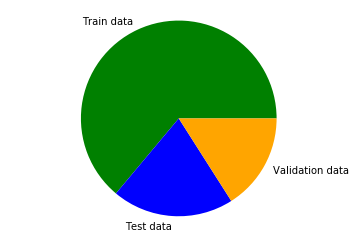

In [129]:
label_s = ['Train data', 'Test data','Validation data']
values = [len(train_generator), len(test_generator), len(validation_generator)]
colors = ['green','blue','orange']
plt.pie(values, labels=label_s, colors=colors)
plt.axis('equal')
plt.show()

{0: 'normal', 1: 'covid', 2: 'pneumonia'}


Text(0.5, 1.0, 'Statistic of train set, \n {0: normal, 1: covid, 2: pneumonia}')

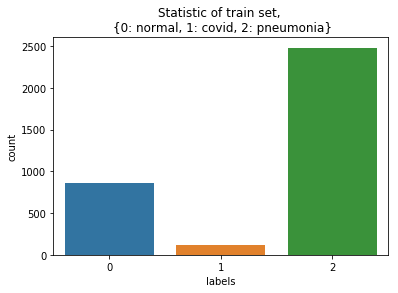

In [99]:
map_characters = {0: 'normal', 1: 'covid', 2: 'pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=train_generator.classes
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
plt.title('Statistic of train set, \n {0: normal, 1: covid, 2: pneumonia}')

{0: 'normal', 1: 'covid', 2: 'pneumonia'}


Text(0.5, 1.0, 'Statistic of test set, \n {0: normal, 1: covid, 2: pneumonia}')

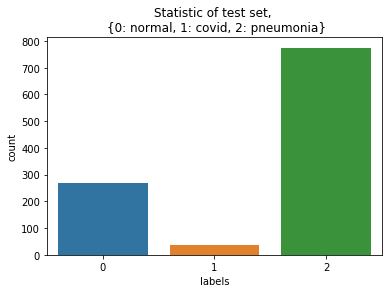

In [100]:
map_characters = {0: 'normal', 1: 'covid', 2: 'pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=test_generator.classes
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
plt.title('Statistic of test set, \n {0: normal, 1: covid, 2: pneumonia}')

{0: 'normal', 1: 'covid', 2: 'pneumonia'}


Text(0.5, 1.0, 'Statistic of validation set, \n {0: normal, 1: covid, 2: pneumonia}')

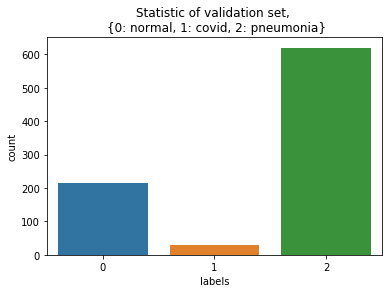

In [101]:
map_characters = {0: 'normal', 1: 'covid', 2: 'pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=validation_generator.classes
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
plt.title('Statistic of validation set, \n {0: normal, 1: covid, 2: pneumonia}')

In [102]:
validation_generator.class_indices

{'normal': 0, 'covid': 1, 'pneumonia': 2}

### Create Model

In [103]:
res = 64

In [104]:
verbose = 0
base_model = DenseNet121(input_shape=(res, res, 3),include_top=False,weights='imagenet',pooling='avg')
x = base_model.output
x = layers.Dense(1024, activation="relu")(x)
output = layers.Dense(3, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy']) #metrics.AUC(name='auc')
if verbose == 0: 
    print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

### Compute Class Weights

In [105]:
import collections
from collections import Counter

In [106]:
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}           
print(f'class_weights {class_weights}')

class_weights {0: 2.8904428904428903, 1: 21.379310344827587, 2: 1.0}


### Train Model

In [107]:
EPOCHS = 25

In [108]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [109]:
es_cb = callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta=0.001)
lr_cb = callbacks.ReduceLROnPlateau(patience=1,min_delta=.05)

history = model.fit(
         train_generator
        ,epochs=EPOCHS
        ,validation_data=validation_generator
        ,callbacks=[MetricsCheckpoint('logs')]
        ,class_weight=class_weights)

Train for 216 steps, validate for 54 steps
Epoch 1/25
216/216 [==============================] - 76s 354ms/step - loss: 1.1079 - accuracy: 0.7519 - val_loss: 1.1194 - val_accuracy: 0.8213
Epoch 2/25
216/216 [==============================] - 59s 272ms/step - loss: 0.5025 - accuracy: 0.8830 - val_loss: 0.4903 - val_accuracy: 0.9037
Epoch 3/25
216/216 [==============================] - 59s 271ms/step - loss: 0.3924 - accuracy: 0.9071 - val_loss: 0.6820 - val_accuracy: 0.8550
Epoch 4/25
216/216 [==============================] - 58s 270ms/step - loss: 0.3567 - accuracy: 0.9137 - val_loss: 0.3037 - val_accuracy: 0.9188
Epoch 5/25
216/216 [==============================] - 58s 268ms/step - loss: 0.4374 - accuracy: 0.9117 - val_loss: 0.7258 - val_accuracy: 0.8492
Epoch 6/25
216/216 [==============================] - 58s 269ms/step - loss: 0.3647 - accuracy: 0.9120 - val_loss: 0.4218 - val_accuracy: 0.8585
Epoch 7/25
216/216 [==============================] - 58s 268ms/step - loss: 0.2689 - a

In [110]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

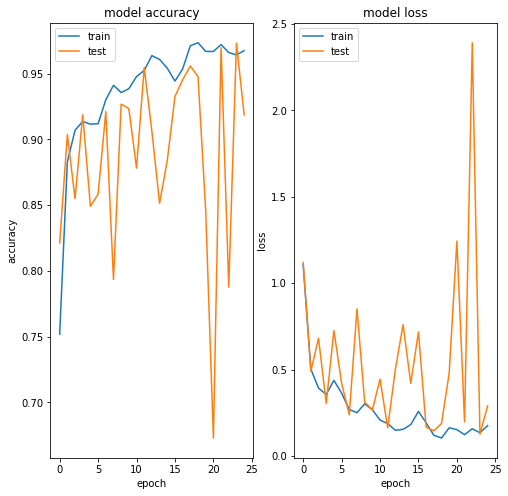

In [111]:
plot_learning_curve(history)

In [112]:
batchSize = 16

In [113]:
train_generator.reset()
score = model.evaluate_generator(train_generator, (train_generator.samples + (batchSize-1)) //batchSize)
print("For train data set; Loss: ",score[0]," Accuracy: ", score[1])

For train data set; Loss:  0.12781478645646766  Accuracy:  0.96004635


In [114]:
validation_generator.reset()
score = model.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("For validation data set; Loss: ",score[0]," Accuracy: ", score[1])

For validation data set; Loss:  0.1969607904719413  Accuracy:  0.9303944


In [115]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) // batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  0.28281710635843305  Accuracy:  0.9222222


In [116]:
test_generator.reset()
testStep = (test_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  68
68/68 [==============================] - 14s 208ms/step


1080

In [117]:
predicted_class_indices=np.argmax(predictions,axis=1)

In [118]:
predicted_class_indices=np.argmax(predictions,axis=1)
labels = (test_generator.class_indices)
print(labels)

{'normal': 0, 'covid': 1, 'pneumonia': 2}


In [119]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'normal', 1: 'covid', 2: 'pneumonia'}


In [120]:
predictedLables= [labels[k] for k in predicted_class_indices]
#print(predictedLables)

In [121]:
actualLables= [labels[k] for k in test_generator.classes]
#print(actualLables)

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [123]:
actualLables= [labels[k] for k in test_generator.classes]
#print(actualLables)
accuracy_score(actualLables, predictedLables)

0.9222222222222223

In [124]:
matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'normal', 1: 'covid', 2: 'pneumonia'}


array([[ 36,   0,   0],
       [  1, 266,   2],
       [  4,  77, 694]])

In [125]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

       covid       0.88      1.00      0.94        36
      normal       0.78      0.99      0.87       269
   pneumonia       1.00      0.90      0.94       775

    accuracy                           0.92      1080
   macro avg       0.88      0.96      0.92      1080
weighted avg       0.94      0.92      0.92      1080



In [126]:
#Prepared code that is taken from SKLearn Website, Creates Confusion Matrix
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 36   0   0]
 [  1 266   2]
 [  4  77 694]]


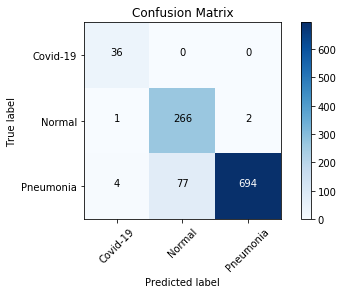

In [127]:
from sklearn.metrics import confusion_matrix
cm_plot_labels = ['Covid-19','Normal','Pneumonia']
plot_confusion_matrix(matrix,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix')

In [128]:
recall_score( actualLables, predictedLables,average='weighted'), precision_score( actualLables, predictedLables,average='weighted') 

(0.9222222222222223, 0.9379583236122845)

## Save Model

In [ ]:
model.save(dataset_path + "/COVID_Detection")